In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load and preprocess the dataset using tf.keras.utils.image_dataset_from_directory
batch_size = 32
image_size = (224, 224)  # Adjust this based on your image size

train_directory = "/content/drive/MyDrive/caers/train"
val_directory = "/content/drive/MyDrive/caers/test"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, x / 255.0))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, x / 255.0))

input_img = Input(shape=(224, 224, 3))
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the autoencoder
autoencoder.fit(train_dataset, epochs=10, validation_data=validation_dataset)

autoencoder.save_weights('/content/drive/MyDrive/caers/model_checkpoints/auto/autoencoder_weights.h5')

# Extract features using the encoder part of the autoencoder
x_train_encoded = autoencoder.predict(train_dataset)
x_val_encoded = autoencoder.predict(validation_dataset)

# Flatten the encoded representations
x_train_encoded_flat = x_train_encoded.reshape((x_train_encoded.shape[0], -1))
x_val_encoded_flat = x_val_encoded.reshape((x_val_encoded.shape[0], -1))

train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

val_labels = []
for _, labels in validation_dataset:
    val_labels.extend(labels.numpy())

# Convert labels to one-hot encoded form
train_labels = to_categorical(train_labels, num_classes=7)
val_labels = to_categorical(val_labels, num_classes=7)

# Define and compile a classifier model
classifier_input = Input(shape=(x_train_encoded_flat.shape[1],))
classifier_output = Dense(7, activation='softmax')(classifier_input)

classifier = Model(classifier_input, classifier_output)
classifier.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier using the flattened encoded representations
hist = classifier.fit(x_train_encoded_flat, train_labels, epochs=10, validation_data=(x_val_encoded_flat, val_labels))
# plot_hist(hist)  # Assuming you have a function to plot the training history

Found 1400 files belonging to 7 classes.
Found 672 files belonging to 7 classes.
Epoch 1/10
44/44 [==============================] - 298s 7s/step - loss: 0.0326 - val_loss: 0.0125
Epoch 2/10
44/44 [==============================] - 293s 7s/step - loss: 0.0085 - val_loss: 0.0086
Epoch 3/10
44/44 [==============================] - 297s 7s/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/10
44/44 [==============================] - 298s 7s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/10
44/44 [==============================] - 300s 7s/step - loss: 0.0045 - val_loss: 0.0099
Epoch 6/10
44/44 [==============================] - 306s 7s/step - loss: 0.0047 - val_loss: 0.0039
Epoch 7/10
44/44 [==============================] - 302s 7s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/10
44/44 [==============================] - 299s 7s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/10
44/44 [==============================] - 290s 7s/step - loss: 0.0033 - val_loss: 0.0038
Epoch 10/10
21/21 [=========

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 224, 224, 3, 7) and (None, 7) are incompatible


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Function to load images and labels from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess the dataset using the load_images_from_directory function
train_directory = "/content/drive/MyDrive/caers/train"
val_directory = "/content/drive/MyDrive/caers/test"

x_train, y_train = load_images_from_directory(train_directory)
x_val, y_val = load_images_from_directory(val_directory)

# Normalize pixel values to be between 0 and 1
x_train, x_val = x_train / 255.0, x_val / 255.0

# Define and compile the autoencoder model
input_img = Input(shape=(224, 224, 3))
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

# Load the autoencoder weights
autoencoder.load_weights('/content/drive/MyDrive/caers/model_checkpoints/auto/autoencoder_weights.h5')

# Extract features using the encoder part of the autoencoder
x_train_encoded = autoencoder.predict(x_train)
x_val_encoded = autoencoder.predict(x_val)

# Flatten the encoded representations
x_train_encoded_flat = x_train_encoded.reshape((x_train_encoded.shape[0], -1))
x_val_encoded_flat = x_val_encoded.reshape((x_val_encoded.shape[0], -1))

# Convert labels to one-hot encoded form
y_train_one_hot = to_categorical(y_train, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)

# Define and compile the classifier model
classifier_input = Input(shape=(x_train_encoded_flat.shape[1],))
classifier_output = Dense(7, activation='softmax')(classifier_input)

classifier = Model(classifier_input, classifier_output)
classifier.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = '/content/drive/MyDrive/caers/model_checkpoints/auto/best_classifier_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Train the classifier using the flattened encoded representations and use the callback
classifier.fit(x_train_encoded_flat, y_train_one_hot, epochs=100, validation_data=(x_val_encoded_flat, y_val_one_hot), callbacks=[checkpoint_callback])

# Save the final model
classifier.save('/content/drive/MyDrive/caers/model_checkpoints/auto/final_classifier_model.h5')

21/21 [==============================] - 34s 2s/step
Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 17.4033 - accuracy: 0.2729
Epoch 1: val_accuracy improved from -inf to 0.42113, saving model to /content/drive/MyDrive/caers/model_checkpoints/auto/best_classifier_model.h5
44/44 [==============================] - 2s 42ms/step - loss: 17.4033 - accuracy: 0.2729 - val_loss: 5.4562 - val_accuracy: 0.4211
Epoch 2/100
43/44 [============================>.] - ETA: 0s - loss: 2.9790 - accuracy: 0.5945
Epoch 2: val_accuracy improved from 0.42113 to 0.53869, saving model to /content/drive/MyDrive/caers/model_checkpoints/auto/best_classifier_model.h5
44/44 [==============================] - 1s 13ms/step - loss: 2.9952 - accuracy: 0.5914 - val_loss: 3.6003 - val_accuracy: 0.5387
Epoch 3/100
43/44 [============================>.] - ETA: 0s - loss: 1.9720 - accuracy: 0.6802
Epoch 3: val_accuracy improved from 0.53869 to 0.54762, saving model to /content/drive/MyDrive/caers/mode

21/21 [==============================] - 0s 4ms/step
[[0.84375    0.         0.         0.08333333 0.02083333 0.02083333
  0.03125   ]
 [0.04166667 0.73958333 0.02083333 0.08333333 0.10416667 0.01041667
  0.        ]
 [0.125      0.07291667 0.77083333 0.02083333 0.01041667 0.
  0.        ]
 [0.03125    0.02083333 0.02083333 0.83333333 0.07291667 0.01041667
  0.01041667]
 [0.10416667 0.05208333 0.         0.04166667 0.72916667 0.04166667
  0.03125   ]
 [0.03125    0.01041667 0.04166667 0.         0.07291667 0.80208333
  0.04166667]
 [0.         0.01041667 0.03125    0.03125    0.17708333 0.02083333
  0.72916667]]


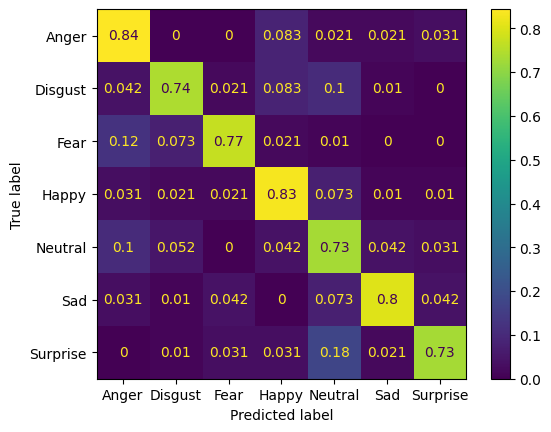

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = classifier.predict(x_val_encoded_flat)

# Convert the true and predicted labels into NumPy arrays
correct_labels_np = tf.argmax(y_val_one_hot, axis=-1).numpy()
predicted_labels_np = np.argmax(y_pred, axis=-1)

# Compute confusion matrix
result = confusion_matrix(correct_labels_np, predicted_labels_np, normalize='true')
print(result)
# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])
cm_display.plot()
plt.show()